# Titanic Classification Project

## Libraries Importing

In [150]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

In [151]:
data=pd.read_csv('Titanic-Dataset.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [152]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [154]:
# Drop irrelevant columns
data.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [155]:
#handling missing values
data.isnull().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


In [156]:
# Fill missing 'Age' with median
data['Age'].fillna(data['Age'].median(), inplace=True)

# Fill missing 'Embarked' with mode
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

#handling missing values
data.isnull().sum()


,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


In [157]:
# Find duplicate rows
duplicates = data[data.duplicated()]

# Number of duplicate rows
print("Number of duplicates:", duplicates.shape[0])


Number of duplicates: 0


In [158]:
# Extract title from name
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
data.drop('Name', axis=1, inplace=True)

In [159]:
# Feature engineering: FamilySize and IsAlone
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = 1
data.loc[data['FamilySize'] > 1, 'IsAlone'] = 0

In [160]:
# Column types for preprocessing
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

## Model Training & Evaluation

In [161]:
# Define features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

Accuracy: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



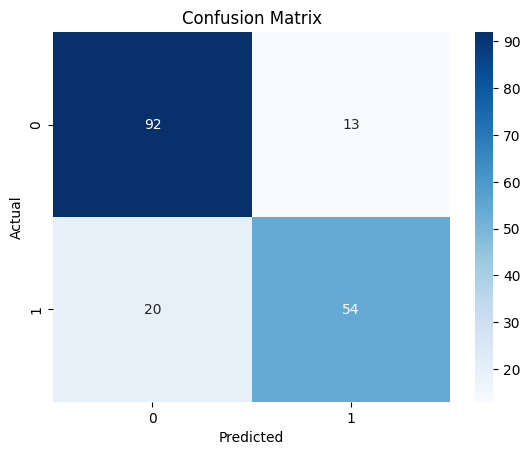

In [162]:
# Build pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Conclusions

### Grouping by Sex:

In [164]:
data.groupby('Sex')['Survived'].mean()

,Survived
Sex,
female,0.742038
male,0.188908


=> 74% of the survivals were women


### Group by Class:

In [165]:
data.groupby('Pclass')['Survived'].mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


=> The survival rate among the **first class** is higher than in the second and third

### Group by Age:

In [166]:
data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100],
                          labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])
data.groupby('AgeGroup')['Survived'].mean()


,Survived
AgeGroup,
Child,0.579710
Teen,0.428571
Young Adult,0.353271
Adult,0.400000
Senior,0.227273


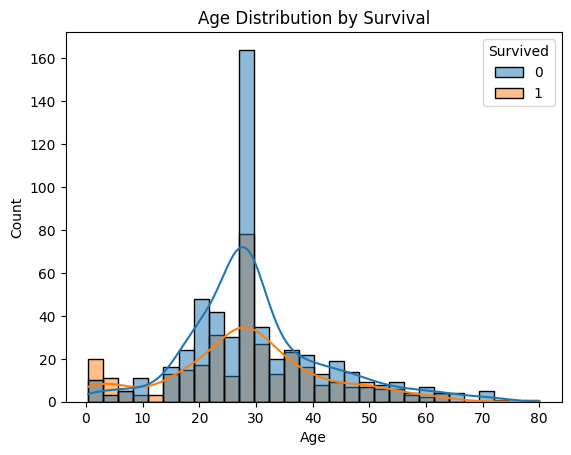

In [170]:
sns.histplot(data=data, x='Age', hue='Survived', bins=30, kde=True)
plt.title('Age Distribution by Survival')
plt.show()

=> Children have higher chances of surviving than other age categories; Teen,Young Adults, Adults, Seniors

### Group by Embarked Location:

In [167]:
data.groupby('Embarked')['Survived'].mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


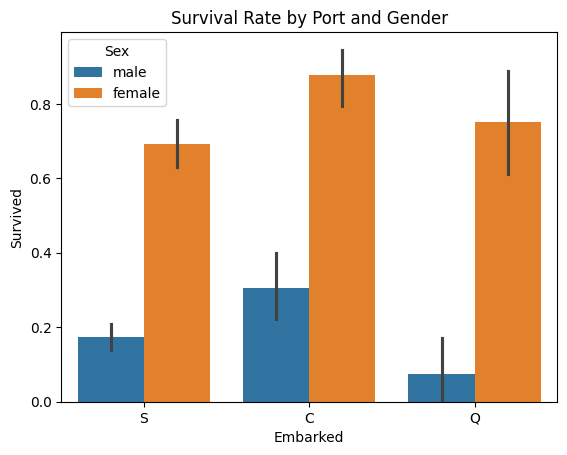

In [171]:
sns.barplot(data=data, x='Embarked', y='Survived', hue='Sex')
plt.title('Survival Rate by Port and Gender')
plt.show()

=> People from Cherbourg (C) usually had a higher survival rate.

### Combining Sex and Pclass

In [168]:
pd.pivot_table(data, index='Sex', columns='Pclass', values='Survived')

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


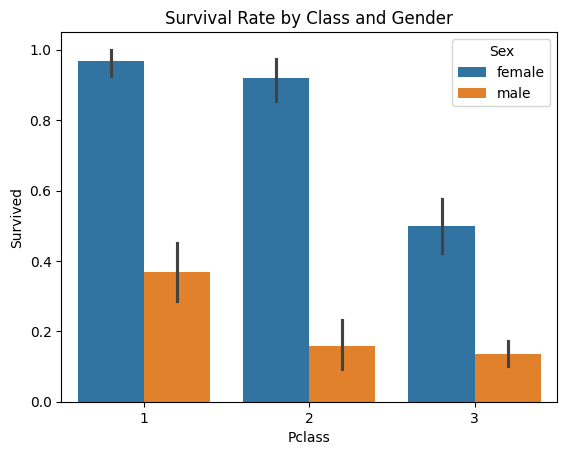

In [169]:
sns.barplot(data=data, x='Pclass', y='Survived', hue='Sex')
plt.title('Survival Rate by Class and Gender')
plt.show()

=> Women in first class have a very high chance (96.8%) of surviving

## Summary

* Females were much more likely to survive than males — especially in 1st class.

* 1st class passengers had a significantly higher survival rate than 3rd class.

* Children under 12 and young adults had better chances, particularly if traveling with family.

* Passengers who embarked from Cherbourg (C) had a higher survival rate.
